In [60]:
#: the usual imports
from datascience import *
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import warnings; warnings.simplefilter('ignore')

def normal_curve(x, mu=0, sigma=1):
    return 1 / np.sqrt(2*np.pi) * np.exp(-(x - mu)**2/(2 * sigma**2))

def plot_sample_mean(sample_size):
    sample = flights.sample(sample_size).column('Delay')

    fig, ax1 = plt.subplots()
    plt.xlim([-10, 80])
    plt.grid('off')
    ax1.hist(sample, density=True, bins=np.arange(0, 200, 5), label='Sample')
    ax2 = ax1.twinx()
    plot_clt_curve(sample_size)
    ax1.set_ylim([-.0, .055])
    ax2.set_ylim([-.01, .5])

    plt.scatter(sample.mean(), 0, marker='^', color='C1', s=200, label='Sample Mean')
    plt.legend(loc='upper right')

plt.style.use('fivethirtyeight')

# Lecture 17

### Normal Confidence Intervals

## Recap: The Central Limit Theorem

Suppose we draw a sample of 500 flights and find the mean flight delay.

Three distributions are involved:

- The population (we don't see this)
- The sample (we see this)
- Distribution of the sample mean (we don't see this directly)
    - a.k.a, sampling distribution of mean
    - a.k.a, empirical distribution of sample mean

## The population (we don't see this)

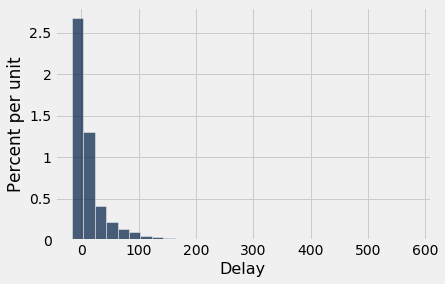

In [61]:
#:
flights = Table.read_table('./united_summer2015.csv')
flights.hist('Delay', bins=30)

## The population

- We don't see:
    - the population distribution,
    - the population mean (fixed!),
    - the population standard deviation (fixed!).

## The sample

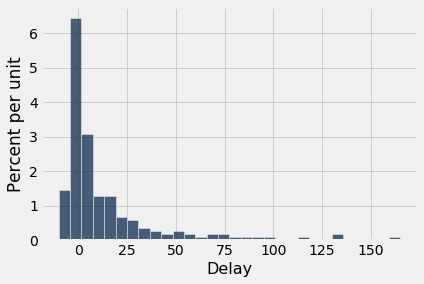

In [69]:
#:
flights.sample(200).hist('Delay', bins=30)

## The sample

- We *do* see (or can calculate):
    - the sample itself (random!),
    - the sample's mean (random!),
    - the sample's standard deviation (random!).

## CLT: Distribution of Sample Mean

- The sample mean is distributed normally.
- Centered at population mean (fixed, unobserved).
- Standard deviation (fixed, unobserved):
$$
    \frac{
        \text{population standard dev.}
    }{
        \sqrt{\text{sample size}}
    }
$$

## The Central Limit Theorem

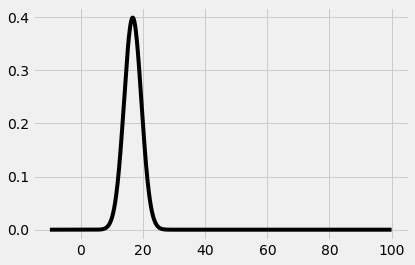

In [73]:
#:
population_mean = flights.column('Delay').mean()
population_sd = flights.column('Delay').std()

def plot_clt_curve(sample_size):
    x = np.linspace(-10, 100, 1000)
    y = normal_curve(x, population_mean, population_sd / np.sqrt(sample_size))
    plt.plot(x, y, color='black')
    
plot_clt_curve(200)

## The Central Limit Theorem

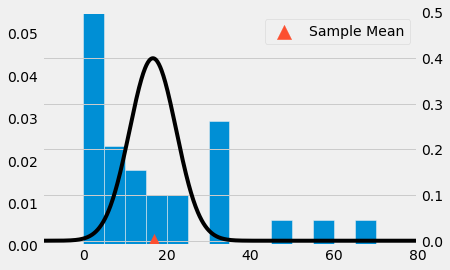

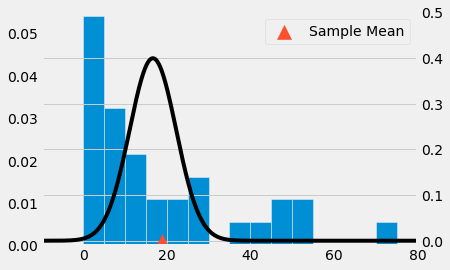

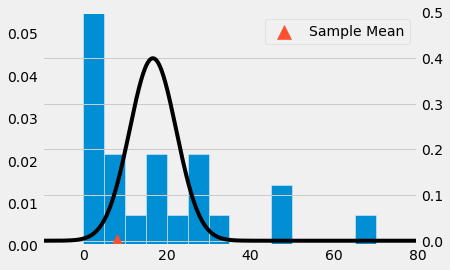

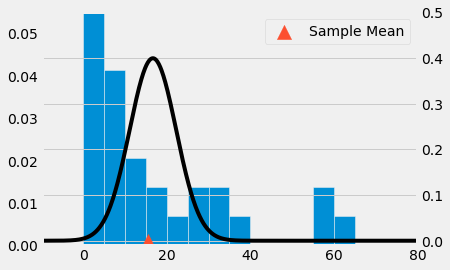

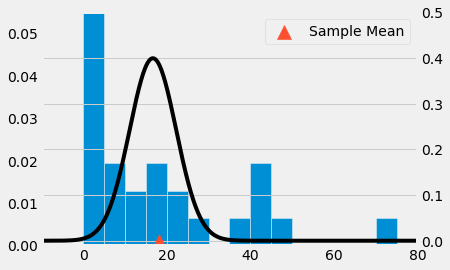

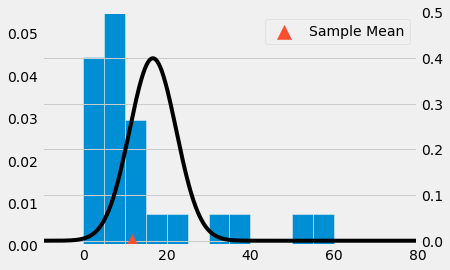

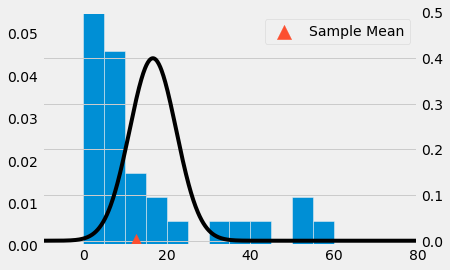

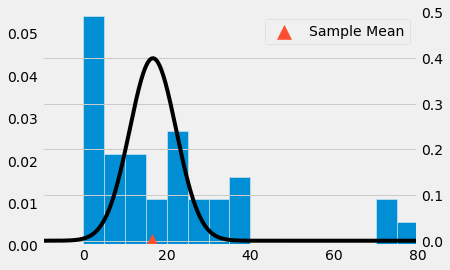

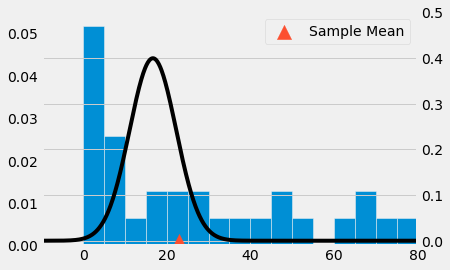

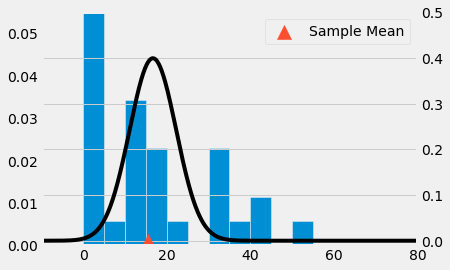

In [77]:
sample_size = 50

for i in range(10):
    plot_sample_mean(sample_size)

# Normal Confidence Intervals

## Normal confidence intervals

- We used bootstrapping to construct confidence intervals.
- But we can often use the CLT.
    - Computationally cheaper!

## Run the bootstrap

In [78]:
#: run the bootstrap for sample mean of flight delays
n_boot = 5000
np.random.seed(42)
sample = flights.sample(400)
boot_means = make_array()

for i in np.arange(n_boot):
    resample = sample.sample()
    boot_mean = resample.column('Delay').mean()
    boot_means = np.append(boot_means, boot_mean)

## Visualize the bootstrap

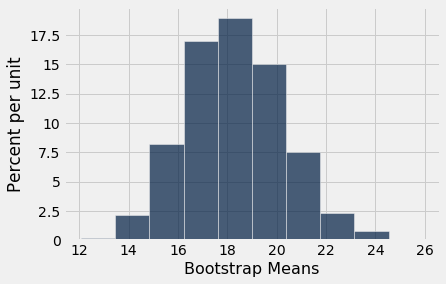

In [79]:
#: visualize
Table().with_column('Bootstrap Means', boot_means).hist()

## Construct 95% confidence interval

In [80]:
#: construct confidence interval
left_boot = percentile(2.5, boot_means)
right_boot = percentile(97.5, boot_means)
[left_boot, right_boot]

[14.655, 22.31]

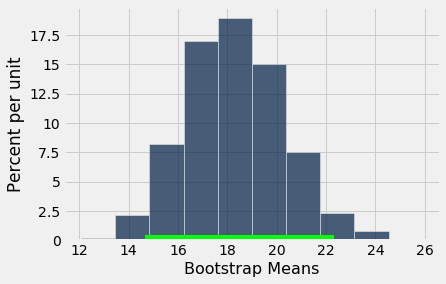

In [81]:
Table().with_column('Bootstrap Means', boot_means).hist()
plt.plot([left_boot, right_boot], [0, 0], color='lime', linewidth=10);

## What did the bootstrap give us?

- We use bootstrap to approximate distribution of sample mean.
- But CLT tells us it is approximately normal!
- We can use the CLT directly to construct CIs.

## Normal confidence intervals

- Draw a normal curve centered at the sample mean
- CLT tells us SD is
$$
    \frac{
        \text{population standard dev.}
    }{
        \sqrt{\text{sample size}}
    }
$$
- Don't know population SD. Instead, use sample SD:
$$
    \frac{
        \text{sample standard dev.}
    }{
        \sqrt{\text{sample size}}
    }
$$

## The normal curve

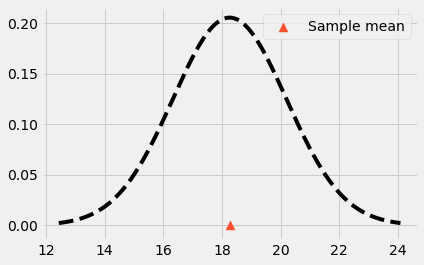

In [82]:
#: draw the normal curve
from scipy import stats
np.random.seed(42)
sample = flights.sample(400).column('Delay')
x = np.linspace(sample.mean() - 3*sample.std()/20, sample.mean() + 3*sample.std()/20, 1000)
y = stats.norm.pdf(x, sample.mean(), sample.std()/20)
plt.plot(x, y, color='black', linestyle='--')
plt.scatter(sample.mean(), 0, marker='^', color='C1', s=80, label='Sample mean')
plt.legend(loc='upper right')

## Computing the confidence interval

- Recall: $\approx$ 95% of normal curve's area falls within $\pm$ 2 SDs of mean
- Don't confuse sample SD with SD of sample mean|! (divide by $\sqrt{n}$)

In [83]:
#: compute confidence interval
left_normal = sample.mean() - 2*sample.std() / np.sqrt(400)
right_normal = sample.mean() + 2*sample.std() / np.sqrt(400)
[left_normal, right_normal]

[14.373653718605743, 22.141346281394256]

## Visualize the confidence interval

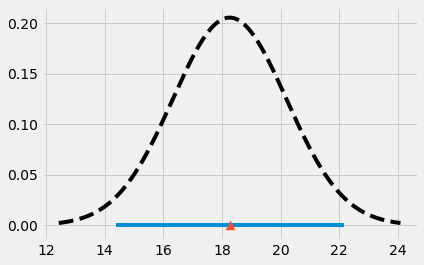

In [84]:
#:
plt.plot(x, y, color='black', linestyle='--')
plt.plot([left_normal, right_normal], [0, 0], zorder=1)
plt.scatter(sample.mean(), 0, marker='^', color='C1', zorder=2, s=80)

## Comparison with bootstrap CI

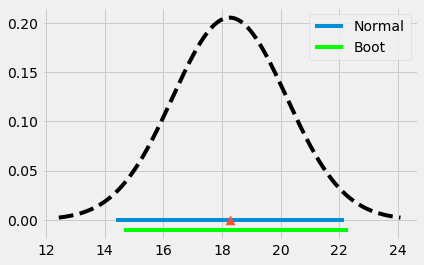

In [85]:
#:
plt.plot(x, y, color='black', linestyle='--')
plt.plot([left_normal, right_normal], [0, 0], zorder=1, label='Normal')
plt.plot([left_boot, right_boot], [-.01, -.01], color='lime', label='Boot')
plt.scatter(sample.mean(), 0, marker='^', color='C1', zorder=2, s=80)
plt.legend()

## Recap

To compute approximate 95% confidence interval for population mean:

$$
\left[
\text{sample mean} - 2\cdot \frac{\text{sample SD}}{\sqrt{n}},
\text{sample mean} + 2\cdot \frac{\text{sample SD}}{\sqrt{n}}
\right]
$$

## So why use the bootstrap?

- We can use CLT to make CIs for:
    - sample mean
    - proportions
- But CLT doesn't apply to, for example, median.
- Have to use bootstrap there.

# Hypothesis testing

## Hypothesis testing for the mean

- We can use the CLT to run hypothesis tests, too.

## Example: Body temperature

- Everyone knows that the average body temperature is 98.6 F (or 37 C).
- We have a data set of body temperatures.

In [87]:
#: temperatures
temperatures = Table.read_table('temp.csv')
temperatures.mean()

temperature
98.2492


## Hypothesis test

- **Null hypothesis**: The population mean is 98.6 F.
- **Alternative hypothesis**: It is significantly less than 98.6 F.

## The null model

- Under null hypothesis, sample mean is distributed normally around 98.6, with s.d.: 
$$
    \frac{
        \text{population standard dev.}
    }{
        \sqrt{\text{sample size}}
    }
$$
- Null hypothesis does not say that temperatures are distributed normally!
- We don't know population s.d., use sample s.d. instead:

In [88]:
sample_mean_sd = temperatures.column('temperature').std() / np.sqrt(temperatures.num_rows)
sample_mean_sd

0.06405661469519337

## The distribution of the sample mean

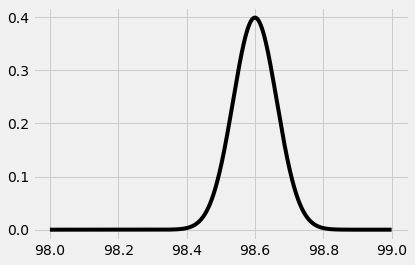

In [89]:
#: 
x = np.linspace(98, 99, 1000)
y = normal_curve(x, 98.6, sample_mean_sd)
plt.plot(x, y, color='black')

sample_mean = temperatures.column('temperature').mean()
# plt.scatter(sample_mean, 0, color='C1', marker='^', s=180, zorder=3)

## The p-value

- How often would we see something so small under the null hypothesis?

In [90]:
#: standardize
z = (sample_mean - 98.6) / sample_mean_sd
z

-5.475925202078115

In [91]:
stats.norm.cdf(z)

2.1761575829410993e-08

## Hypothesis testing

- We reject the null hypothesis, as the probability of seeing something this small is very low.
- What gives?
- 98.6 F is due to Carl Reinhold August Wunderlich, 19th century physician.
- His thermometer was miscalibrated.
- Later experiment: (36.88 C $\approx$ 98.38 F), but rounded up to (37 C $\approx$ 98.6 F)

## A confidence interval

- A 95% confidence interval for the mean body temperature is:

In [92]:
#::
[sample_mean - 2*sample_mean_sd, sample_mean + 2*sample_mean_sd]

[98.12111753984038, 98.37734399862117]

- Careful! This doesn't mean that 95% of temperatures fall in this range!

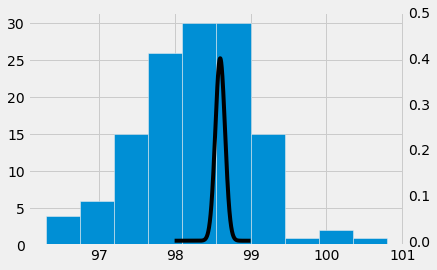

In [93]:
#:
plt.hist(temperatures.column('temperature'));
ax2 = plt.gca().twinx()
ax2.plot(x, y, color='black')
ax2.set_ylim([-.01, .5])
ax2.grid('off')

# Experiment Design

## Example: Polling

- You are conducting a campus poll:
    - Yes/No: Does Eleanor Roosevelt College exist?
- You want to estimate the proportion in population who believe "Yes".
- Need to be accurate to within $\pm$ 3%, 95% of the time.
- i.e., your 95% confidence interval should be 6% wide.
- How big of a sample do you need?

## Proportions are just means

- When polling, we'll write 1 if a person answers "Yes", 0 otherwise.
- The sample proportion in favor of A = mean of 0's and 1's
- I.e., it is the mean of random sample.
- Hence the CLT applies.

## Our strategy

1. We will poll a random sample of $n$ people
2. Compute sample mean (i.e., proportion in favor of A)
3. Compute sample standard deviation
4. Construct 95% confidence interval:
$$
\left[
\text{sample mean} - 2\cdot \frac{\text{sample SD}}{\sqrt{n}},
\text{sample mean} + 2\cdot \frac{\text{sample SD}}{\sqrt{n}}
\right]
$$

## Our strategy

- We want a CI whose width is 4% or less.
- The width of our confidence interval depends on two things:
    - sample SD
    - $\sqrt{n}$
- If we know SD, we can pick $n$ to make CI the right size.
- But before polling, we don't know the sample SD (we don't have a sample!)

## Bounding the sample SD

- How big could the sample SD be?
- This is a simple calculation, but...
- Let's try to get the answer from a plot.

## Create a population

In [96]:
#: construct an array of zeros/ones
def polling_population(size, number_of_ones):
    count = np.arange(size)
    return np.where(count < number_of_ones, 1, 0)

In [98]:
polling_population(10, 3)

array([1, 1, 1, 0, 0, 0, 0, 0, 0, 0])

## Compute standard deviations

In [99]:
#: compute SD for each proportion
size = 100
proportions = np.arange(0, size+1, 10)
sds = make_array()

for proportion in proportions:
    population = polling_population(size, proportion)
    sd = np.std(population)
    sds = np.append(sds, sd)

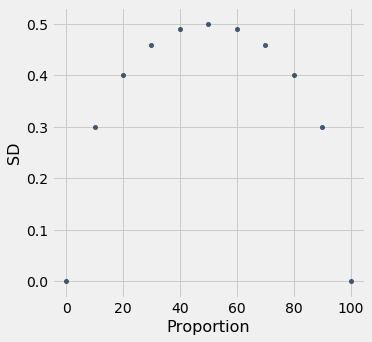

In [101]:
Table().with_columns(
    'Proportion', proportions,
    'SD', sds
).scatter('Proportion')

## Bounding the sample SD

- The most the sample SD can be is 0.5.
- Doesn't depend on size of sample.
- True for the population, too!
- Using 0.5 in place of SD results in a conservative confidence interval.

## Constructing the 95% confidence interval

- The interval is:

$$
\left[
\text{sample mean} - 2\cdot \frac{\text{sample SD}}{\sqrt{n}},
\text{sample mean} + 2\cdot \frac{\text{sample SD}}{\sqrt{n}}
\right]
$$

- The width is:

$$
4 \cdot \frac{\text{sample SD}}{\sqrt{n}}
$$

- Use 0.5 instead of sample SD:

$$
4 \cdot \frac{0.5}{\sqrt{n}} = \frac{2}{\sqrt{n}}
$$

## Constructing the 95% confidence interval

- Upper bound on CI width: $2 / \sqrt{n}$
- Want our sample mean to be within $\pm$ 3%.
- I.e., want our CI to be smaller than 6% = .06.
- Solve for $n$:

$$
\sqrt{n} = \frac{2}{0.06}
$$

In [53]:
(2/.06)**2

1111.1111111111113

## Answer

- We must poll $\approx$ 1111 people to get a 95% CI which is 6% wide.

## Discussion question

We must poll 1111 people to get a 95% CI which is 6% wide.
Suppose we instead want a CI that is 3% wide. How many people do we need to poll?

- A) 555
- B) 2222
- C) 4444
- D) 8888

## Answer: the $\sqrt{\quad}$ rule

- We need 4444 samples.
- To double our accuracy, we must *quadruple* our sample size.

## Experiment

- Let's see how accurate this is.
- Code below chooses some true proportion in favor of A. Don't peek!

In [54]:
#: don't peek
population_proportion = np.random.choice(np.arange(.3, .7, .01))

## Conduct a poll

In [55]:
#:
poll_results = sample_proportions(1111, [population_proportion, 1-population_proportion])
poll_results

array([0.33573357, 0.66426643])

## Repeat the poll

In [56]:
#: simulate 5000 polls
distribution = make_array()

for i in np.arange(5000):
    poll_results = sample_proportions(1111, [population_proportion, 1-population_proportion])
    distribution = np.append(distribution, poll_results.item(0))

## Visualize

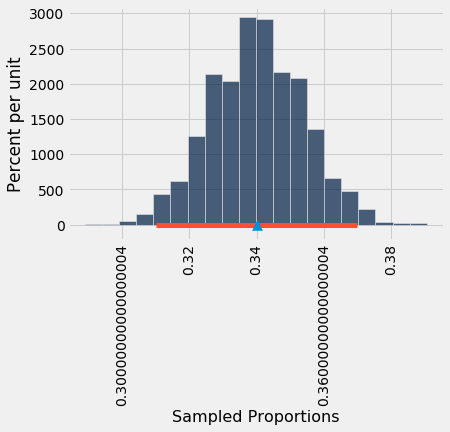

In [57]:
#: draw histogram
Table().with_column('Sampled Proportions', distribution).hist(bins=20)

plt.scatter(population_proportion, 0, marker='^', zorder=3, s=100)
plt.plot([population_proportion - .03, population_proportion + .03], [0, 0], color='C1', linewidth=5)

In [58]:
np.count_nonzero((population_proportion - .03 <= distribution) & (distribution <= population_proportion + .03)) / 5000

0.9704